In [1]:
import pandas as pd

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
%run ~/Code/FF-power-consumption/energy_consumption/reduction/experiment_reduction.py

ModuleNotFoundError: No module named '__main__.experiment'; '__main__' is not a package

In [126]:
pc.tabs[0]

{'0': {'children': [{'dispatchCount': 4,
    'duration': 0,
    'host': 'moz-nullprincipal:{c7645d78-33d7-4948-b215-b2357340484e}',
    'isWorker': False}],
  'dispatchCount': 4,
  'duration': 0,
  'host': 'moz-nullprincipal:{c7645d78-33d7-4948-b215-b2357340484e}',
  'windowId': 0},
 '1': {'children': [{'dispatchCount': 10,
    'duration': 227877,
    'host': 'resource://gre/modules/osfile/osfile_async_worker.js',
    'isWorker': True},
   {'dispatchCount': 0,
    'duration': 43614,
    'host': 'resource:///modules/sessionstore/SessionWorker.js',
    'isWorker': True}],
  'dispatchCount': 126,
  'duration': 272014,
  'host': 'resource://gre/modules/osfile/osfile_async_worker.js',
  'windowId': 1},
 '10': {'children': [],
  'dispatchCount': 2,
  'duration': 0,
  'host': 'about:blank',
  'windowId': 10},
 '13': {'children': [],
  'dispatchCount': 2,
  'duration': 0,
  'host': 'about:blank',
  'windowId': 13},
 '16': {'children': [],
  'dispatchCount': 2,
  'duration': 0,
  'host': 'about

In [55]:
def read_and_munge_data(fn, expid, ts, path):
    ipg = pd.read_csv(
        '{path}/exp_{expid}_{ts}/ipg_{expid}_1_clean.txt'.format(expid=expid, ts=ts, path=path)
    )
    pc = pd.read_json(
        '{path}/exp_{expid}_{ts}/{fn}_{expid}_perf_counters.json'.format(expid=expid, ts=ts, path=path, fn=fn)
    )
    bla = "{} {}".format(pc.timestamp.dt.date[0], ipg.loc[0, 'System Time'])
    assert bla[-4] == ':'
    b2 = bla.split(':')
    ipg['t'] = ipg['Elapsed Time (sec)'].apply(lambda x: pd.Timedelta(x, 's'))
    ipgt0 = pd.Timestamp(':'.join(b2[:-1]) + '.' + b2[-1]) - ipg.loc[0, 't']
    pc['t'] = pc.timestamp - ipgt0
    
    # Pandas doesn't plot timedeltaindex things nicely
    ipg['t'] = ipg['t'].values.astype('int') * 1e-9
    pc['t'] = pc['t'].values.astype('int') * 1e-9

    return ipg.set_index('t'), pc.set_index('t')

In [53]:
def plot_compare(ipg, pc, expid, ts):
    cla()
    ipg['Processor Power_0(Watt)'].plot(label='IPG power (Watt)')
    ylabel('Power consumption (W)')
    legend()
    pc.tabs.apply(lambda x: sum(y['dispatchCount'] for y in x.values())).diff().apply(
        lambda x: x if x >= 0 else np.nan
    ).plot(secondary_y=True)
    ylabel('sum of dispatchCount / sec')
    title('{} {}'.format(expid, ts))

/home/felix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


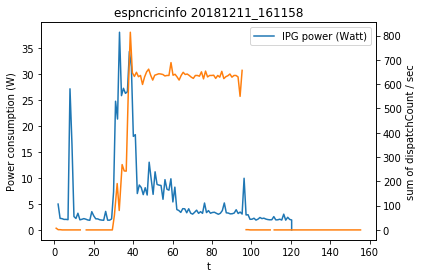

In [56]:
expid, ts = 'espncricinfo', '20181211_161158'
ipg, pc = read_and_munge_data(expid, expid, ts, '~/felix-ec')
plot_compare(ipg, pc, expid, ts)

/home/felix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


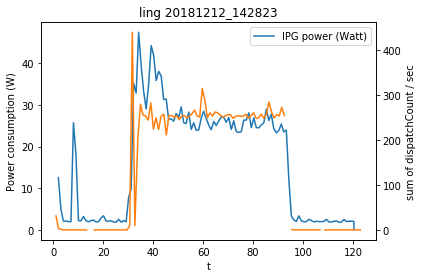

In [57]:
expid, ts = 'ling', '20181212_142823'
ipg, pc = read_and_munge_data(expid, expid, ts, '~/felix-ec')
plot_compare(ipg, pc, expid, ts)

In [6]:
import sklearn.cluster as skc

In [7]:
kipg = skc.KMeans(3)
kipg.fit(ipg['Processor Power_0(Watt)'].values.reshape((-1,1)))
print(expid, ts, 'ipg')
ipg_vals = np.sort(kipg.cluster_centers_[:,0])
ipg_vals

espncricinfo 20181211_161158 ipg


array([ 2.80918391,  9.7926087 , 28.2565    ])

In [8]:
kpc = skc.KMeans(3)
kpc.fit(pc.tabs.apply(lambda x: sum(y['dispatchCount'] for y in x.values())).diff().apply(
        lambda x: x if x >= 0 else np.nan
    ).dropna().values.reshape((-1,1)))
print(expid, ts, 'pc')
pc_vals = np.sort(kpc.cluster_centers_[:,0])
pc_vals

espncricinfo 20181211_161158 pc


/home/felix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


array([  1.75581395, 236.25      , 637.42105263])

In [9]:
(ipg_vals[1] - ipg_vals[0]) / (pc_vals[2] - pc_vals[0])

0.01098601018694794

In [111]:
kipg = skc.KMeans(3)
kipg.fit(ipg['Processor Power_0(Watt)'].values.reshape((-1,1)))
print(expid, ts, 'ipg')
ipg_vals = np.sort(kipg.cluster_centers_[:,0])
ipg_vals

ling 20181212_142823 ipg


array([ 2.82401786, 25.90877358, 38.22527273])

In [112]:
kpc = skc.KMeans(2)
kpc.fit(pc.tabs.apply(lambda x: sum(y['dispatchCount'] for y in x.values())).diff().apply(
        lambda x: x if x >= 0 else np.nan
    ).dropna().values.reshape((-1,1)))
print(expid, ts, 'pc')
pc_vals = np.sort(kpc.cluster_centers_[:,0])
pc_vals

ling 20181212_142823 pc


/home/felix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


array([  1.        , 257.49152542])

In [113]:
(ipg_vals[1] - ipg_vals[0]) / (pc_vals[1] - pc_vals[0])

0.09000202127390507

In [141]:
pc.iloc[50,0]

{'0': {'children': [{'dispatchCount': 5,
    'duration': 0,
    'host': 'moz-nullprincipal:{c7645d78-33d7-4948-b215-b2357340484e}',
    'isWorker': False}],
  'dispatchCount': 5,
  'duration': 0,
  'host': 'moz-nullprincipal:{c7645d78-33d7-4948-b215-b2357340484e}',
  'windowId': 0},
 '1': {'children': [{'dispatchCount': 12,
    'duration': 230706,
    'host': 'resource://gre/modules/osfile/osfile_async_worker.js',
    'isWorker': True},
   {'dispatchCount': 3,
    'duration': 62116,
    'host': 'resource:///modules/sessionstore/SessionWorker.js',
    'isWorker': True}],
  'dispatchCount': 157,
  'duration': 293700,
  'host': 'resource://gre/modules/osfile/osfile_async_worker.js',
  'windowId': 1},
 '4294967297': {'children': [],
  'dispatchCount': 16,
  'duration': 2083,
  'host': 'dfd84cef-f842-2344-b4e3-ea9bfc02a9a5',
  'windowId': 4294967297},
 '4294967298': {'children': [],
  'dispatchCount': 16,
  'duration': 2291,
  'host': 'd4b5efe4-5a1a-b74d-b4d2-889fa01e9dca',
  'windowId': 42

In [146]:
def sum_dispatchCounts(d):
    return sum(sum_dispatchCounts(c) for c in d.get('children', [])) + d['dispatchCount']

In [147]:
sum(sum_dispatchCounts(d) for d in pc.iloc[50,0].values())

/home/felix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.
/home/felix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


12319

In [182]:
def plot_compare2(ipg, pc, expid, ts):
    cla()
    ipg['Processor Power_0(Watt)'].plot(label='IPG power (Watt)')
    ylabel('Power consumption (W)')
    pc.tabs.apply(lambda x: sum(y['dispatchCount'] for y in x.values())).diff().apply(
        lambda x: x if x >= 0 else np.nan
    ).plot(secondary_y=True, label='parent_sum')
#     pc.tabs.apply(lambda x: sum(sum_dispatchCounts(d) for d in x.values())).diff().apply(
#         lambda x: x if x >= 0 else np.nan
#     ).plot(secondary_y=True, label='deep_sum')
    legend()
    ylabel('sum of dispatchCount / sec')
    title('{} {}'.format(expid, ts))

/home/felix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """


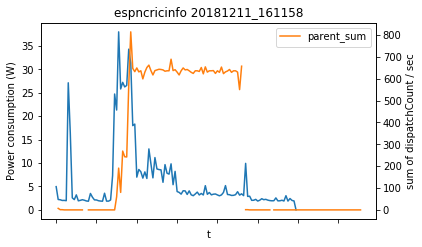

In [183]:
plot_compare2(ipg, pc, expid, ts)

In [155]:
def sum_durations(d):
    return sum(sum_durations(c) for c in d.get('children', [])) + d['duration']

In [185]:
def plot_compare3(ipg, pc, expid, ts):
    cla()
    ipg['Processor Power_0(Watt)'].plot(label='IPG power (Watt)')
    ylabel('Power consumption (W)')
    pc.tabs.apply(lambda x: sum(y['duration'] for y in x.values())).diff().apply(
        lambda x: x if x >= 0 else np.nan
    ).plot(secondary_y=True, label='parent_sum')
#     pc.tabs.apply(lambda x: sum(sum_durations(d) for d in x.values())).diff().apply(
#         lambda x: x if x >= 0 else np.nan
#     ).plot(secondary_y=True, label='deep_sum')
    legend()
    ylabel('sum of duration / sec')
    title('{} {}'.format(expid, ts))

/home/felix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """


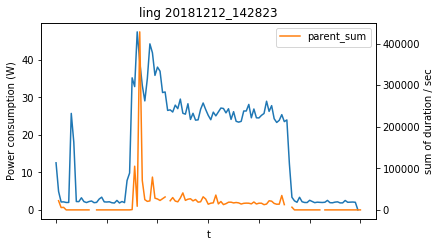

In [186]:
plot_compare3(ipg, pc, expid, ts)

In [165]:
kipg = skc.KMeans(3)
kipg.fit(ipg['Processor Power_0(Watt)'].values.reshape((-1,1)))
print(expid, ts, 'ipg')
ipg_vals = np.sort(kipg.cluster_centers_[:,0])
ipg_vals

espncricinfo 20181211_161158 ipg


array([ 2.80918391,  9.7926087 , 28.2565    ])

In [166]:
kpc = skc.KMeans(3)
kpc.fit(pc.tabs.apply(lambda x: sum(y['duration'] for y in x.values())).diff().apply(
        lambda x: x if x >= 0 else np.nan
    ).dropna().values.reshape((-1,1)))
print(expid, ts, 'pc')
pc_vals = np.sort(kpc.cluster_centers_[:,0])
pc_vals

espncricinfo 20181211_161158 pc


/home/felix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


array([   610.23255814,  86906.69230769, 273659.        ])

In [167]:
(ipg_vals[1] - ipg_vals[0]) / (pc_vals[2] - pc_vals[0])

2.5575741846529873e-05

In [169]:
kipg = skc.KMeans(3)
kipg.fit(ipg['Processor Power_0(Watt)'].values.reshape((-1,1)))
print(expid, ts, 'ipg')
ipg_vals = np.sort(kipg.cluster_centers_[:,0])
ipg_vals

ling 20181212_142823 ipg


array([ 2.82401786, 25.90877358, 38.22527273])

In [176]:
kpc = skc.KMeans(3)
kpc.fit(pc.tabs.apply(lambda x: sum(y['duration'] for y in x.values())).diff().apply(
        lambda x: x if x >= 0 else np.nan
    ).dropna().values.reshape((-1,1)))
print(expid, ts, 'pc')
pc_vals = np.sort(kpc.cluster_centers_[:,0])
pc_vals

ling 20181212_142823 pc


/home/felix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


array([ 10609.24545455,  84916.        , 428243.        ])

In [177]:
(ipg_vals[1] - ipg_vals[0]) / (pc_vals[1] - pc_vals[0])

0.0003106683351866958

In [46]:
dbipg = skc.DBSCAN()
dbipg.fit(ipg['Processor Power_0(Watt)'].values.reshape((-1,1)))

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

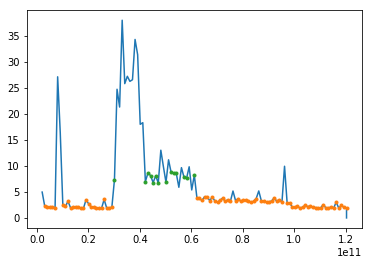

In [29]:
plot(ipg.index, ipg['Processor Power_0(Watt)'])
for i in range(ipg.dbscan_cluster.max() + 1):
    bla = ipg[ipg.dbscan_cluster == i]
    plot(bla.index, bla['Processor Power_0(Watt)'], '.')

In [60]:
def read_and_munge_data2(expid, ts, path):
    ipg = pd.read_csv(
        '{path}/exp_{expid}_{ts}/ipg_{expid}_1_clean.txt'.format(expid=expid, ts=ts, path=path)
    )
    pc = pd.read_json(
        '{path}/exp_{expid}_{ts}/ff_perf_counter_sampled_data.json'.format(expid=expid, ts=ts, path=path)
    )
    bla = "{} {}".format(pc.timestamp.dt.date[0], ipg.loc[0, 'System Time'])
    assert bla[-4] == ':'
    b2 = bla.split(':')
    ipg['t'] = ipg['Elapsed Time (sec)'].apply(lambda x: pd.Timedelta(x, 's'))
    ipgt0 = pd.Timestamp(':'.join(b2[:-1]) + '.' + b2[-1]) - ipg.loc[0, 't']
    pc['t'] = pc.timestamp - ipgt0
    
    # Pandas doesn't plot timedeltaindex things nicely
    ipg['t'] = ipg['t'].values.astype('int') * 1e-9
    pc['t'] = pc['t'].values.astype('int') * 1e-9

    return ipg.set_index('t'), pc.set_index('t')

/home/felix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


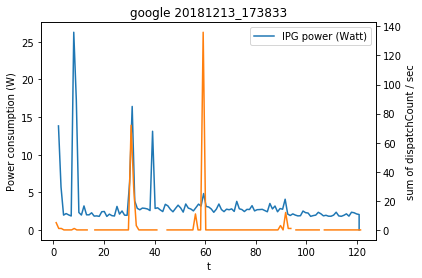

In [64]:
expid, ts = 'google', '20181213_173833'
ipg, pc = read_and_munge_data2(expid, ts, '~/felix-ec/kahuna_1')
plot_compare(ipg, pc, expid, ts)

/home/felix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


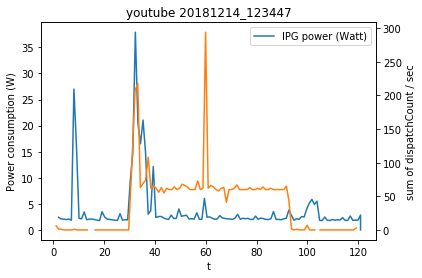

In [72]:
expid, ts = 'youtube', '20181214_123447'
ipg, pc = read_and_munge_data2(expid, ts, '~/felix-ec/kahuna_2')
plot_compare(ipg, pc, expid, ts)

/home/felix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


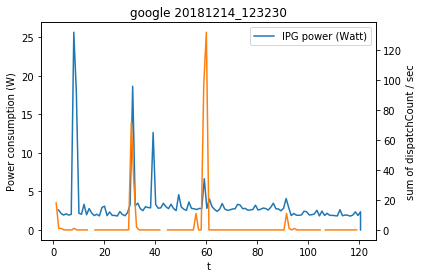

In [70]:
expid, ts = 'google', '20181214_123230'
ipg, pc = read_and_munge_data2(expid, ts, '~/felix-ec/kahuna_2')
plot_compare(ipg, pc, expid, ts)